In [1]:
# Zihan Chen z5527498

# Task A

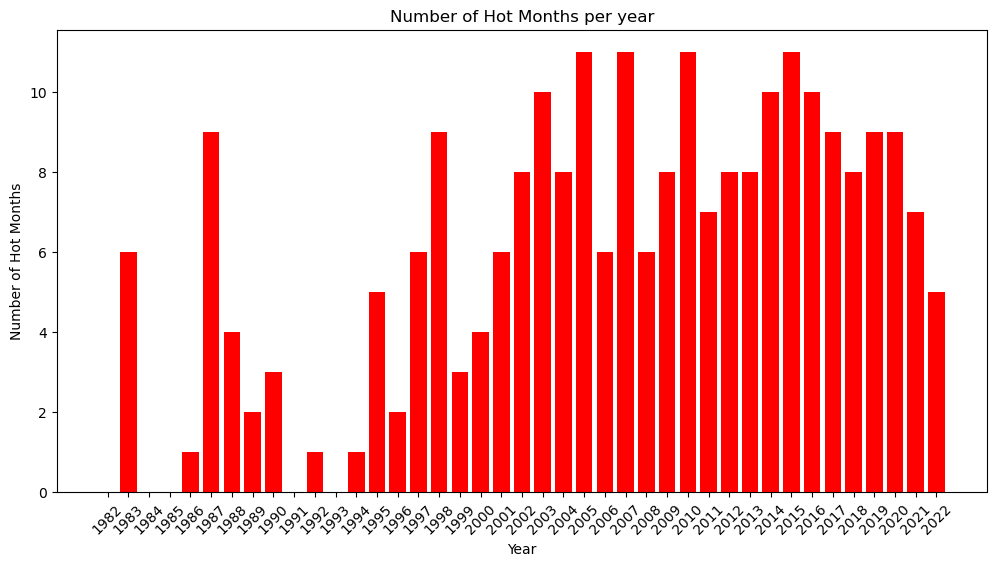

In [2]:
# Data preparation
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# load csv file
temperature = pd.read_csv('Amazon_temperature_student.csv')
threshold = pd.read_csv('thresholds.csv')

# step a
# merge datasets as month to get the thresholds per month
hot_data = pd.merge(temperature, threshold, on='month', how='left')

# add Hot label if > threshold
hot_data['Hot'] = (hot_data['temperature'] > hot_data['threshold']).astype(int)

# step b
# count the number of Hot months per year
hot_month = hot_data.groupby('year')['Hot'].sum().reset_index()

# bar chart
plt.figure(figsize=(12, 6))
plt.bar(hot_month['year'], hot_month['Hot'], color='red')
plt.xlabel('Year')
plt.ylabel('Number of Hot Months')
plt.title('Number of Hot Months per year')
plt.xticks(ticks=hot_month['year'], rotation=45)
plt.show()


Trainable Parameters: 25
Sample Count: 294


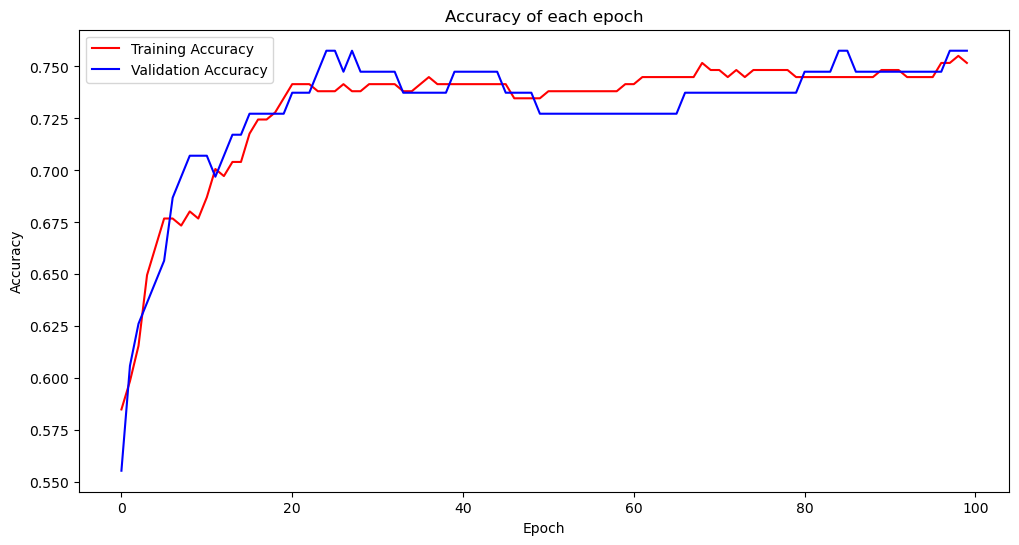

In [3]:
# Model development
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import random
import joblib

# set random seed
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# input features
features = ['TSA', 'ENSO', 'NAO', 'TNA']
x = hot_data[features].values           # (N, 4)
y = hot_data['Hot'].values              # binary

# step c
# 80% for train + validation, 20% for test
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
# 75% for train, 25% for validation
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42) # 0.25*0.8=0.2

# step d
# standardize input features
scalerA = StandardScaler()
sc_x_train = scalerA.fit_transform(x_train)   #  fit scaler only on train data
sc_x_val = scalerA.transform(x_val)

# step e
# set up model
modelA = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(x.shape[1],)),       # 4 input features
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),   # binary
])

# complie model
modelA.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

# count parameters and sample
print("Trainable Parameters:", modelA.count_params())
print("Sample Count:", len(x_train))

# model training
detailA = modelA.fit(
    sc_x_train, y_train,
    validation_data = (sc_x_val, y_val),
    epochs = 100, verbose = 0
)

# step f
# accuracy per epoch
plt.figure(figsize=(12, 6))
plt.plot(detailA.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(detailA.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of each epoch')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


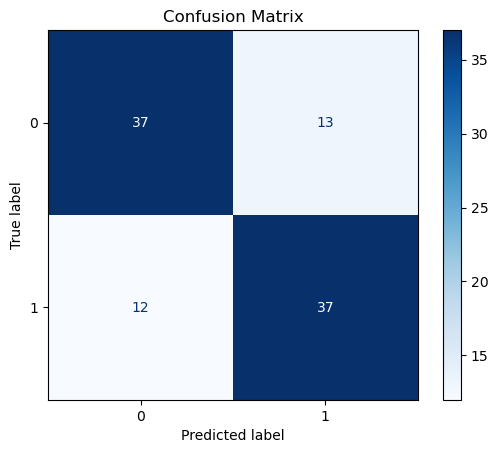

Balanced Accuracy: 0.7476
True Negative Rate: 0.7400
True Positive Rate: 0.7551


['scaler_taskA.pkl']

In [4]:
# Model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
import joblib

# step g
# standardize input features
sc_x_test = scalerA.transform(x_test)

# step h
# get the predicted probability and turn to label
y_pro = modelA.predict(sc_x_test)
y_pred = (y_pro > 0.5).astype(int).flatten()  # turn to 1/0

# step i
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
cmp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# step j
# calculate metrics
tn, fp, fn, tp = cm.ravel()

tnr = tn / (tn + fp)
tpr = tp / (tp + fn)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"True Negative Rate: {tnr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")

# save train model and scaler
modelA.save('model_taskA.keras')
joblib.dump(scalerA, 'scaler_taskA.pkl')

# Task B

Trainable Parameters: 25
Sample Count: 294
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Absolute Error(MAE): 0.9273
Pearson Correlation Coefficient(r): 0.2915


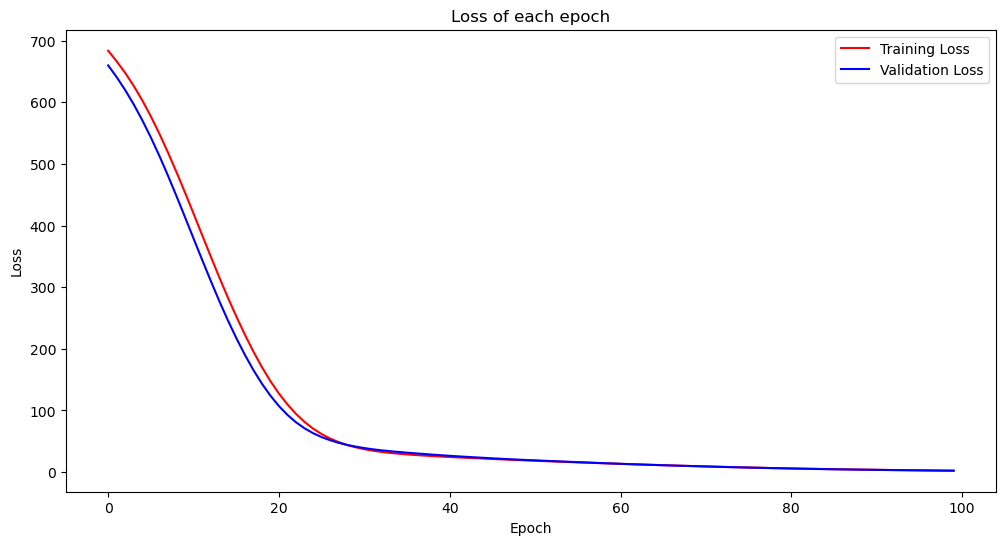

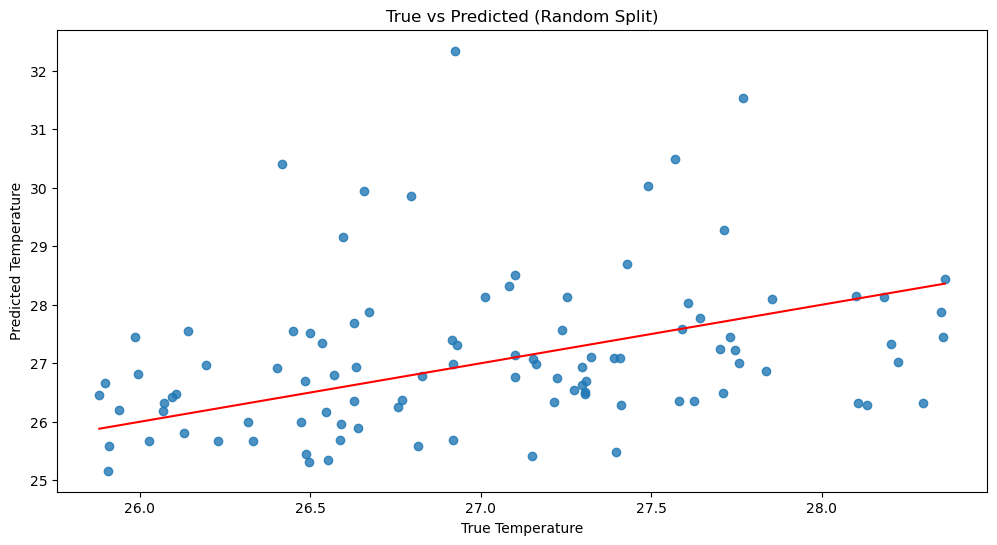

['scaler_taskB.pkl']

In [5]:
#  Model development + Model evaluation (Random split)
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import random
import joblib

# set random seed
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# add month - cyclic encoding
month = 2 * np.pi * (hot_data['month'] - 1) / 12
hot_data['month_sin'] = np.sin(month)
hot_data['month_cos'] = np.cos(month)

# input features
features = ['TSA', 'ENSO', 'NAO', 'TNA', 'month_sin', 'month_cos']
x = hot_data[features].values               # (N, 4)
y = hot_data['temperature'].values          # predict temperature

# step k
# split data: 60% - 20% - 20%
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42) # 0.25*0.8=0.2

# step l
# standardize input features
scalerB = StandardScaler()
sc_x_train = scalerB.fit_transform(x_train)   #  fit scaler only on train data
sc_x_val = scalerB.transform(x_val)

# step m
# set up model
modelB = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(sc_x_train.shape[1],)),   # 6 input features
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1)                                   # no activation forr regression
])

# complie model
modelB.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.007),
    loss = 'mean_squared_error',
)

# count parameters and sample
print("Trainable Parameters:", modelB.count_params())
print("Sample Count:", len(x_train))

# add earlystop
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

# step n
# model training
detailB = modelB.fit(
    sc_x_train, y_train,
    validation_data = (sc_x_val, y_val),
    epochs = 100, batch_size = 32, callbacks = [early_stop], verbose = 0
)

# step o
# scale test features
sc_x_test = scalerB.transform(x_test)
# predict temperatures
y_pred = modelB.predict(sc_x_test).flatten()

# calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# calculate r
r, _ = pearsonr(y_test, y_pred)

# print metrics
print(f"Mean Absolute Error(MAE): {mae:.4f}")
print(f"Pearson Correlation Coefficient(r): {r:.4f}")


# loss per epoch curve
plt.figure(figsize=(12, 6))
plt.plot(detailB.history['loss'], color='red', label='Training Loss')
plt.plot(detailB.history['val_loss'], color='blue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of each epoch')
plt.legend()
plt.show()

# true vs predicted scatter
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.8)
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.title('True vs Predicted (Random Split)')
plt.show()

# save train model and scaler
modelB.save('model_taskB.keras')
joblib.dump(scalerB, 'scaler_taskB.pkl')

Trainable Parameters: 25
Sample Count: 288
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000019C050F39C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Mean Absolute Error(MAE): 0.3836
Pearson Correlation Coefficient(r): 0.7564


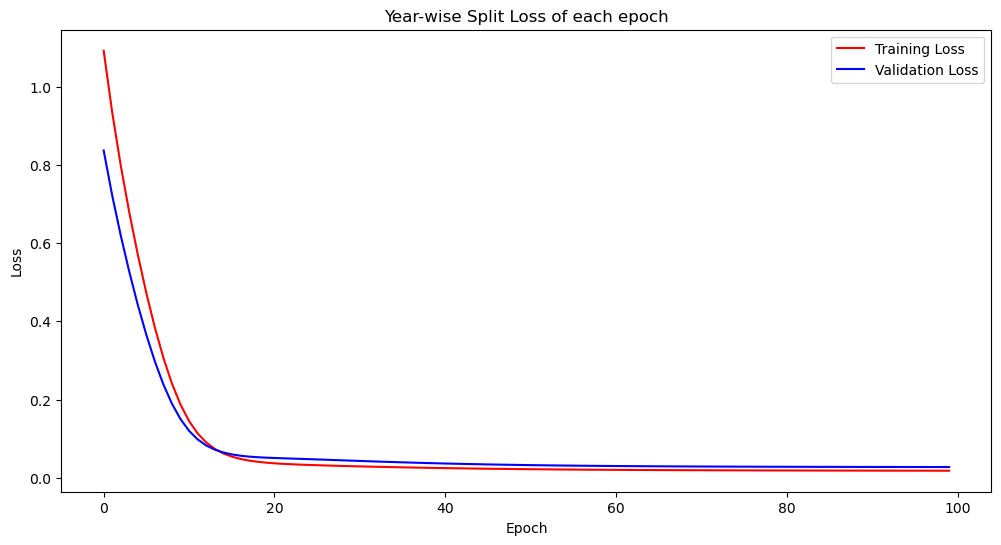

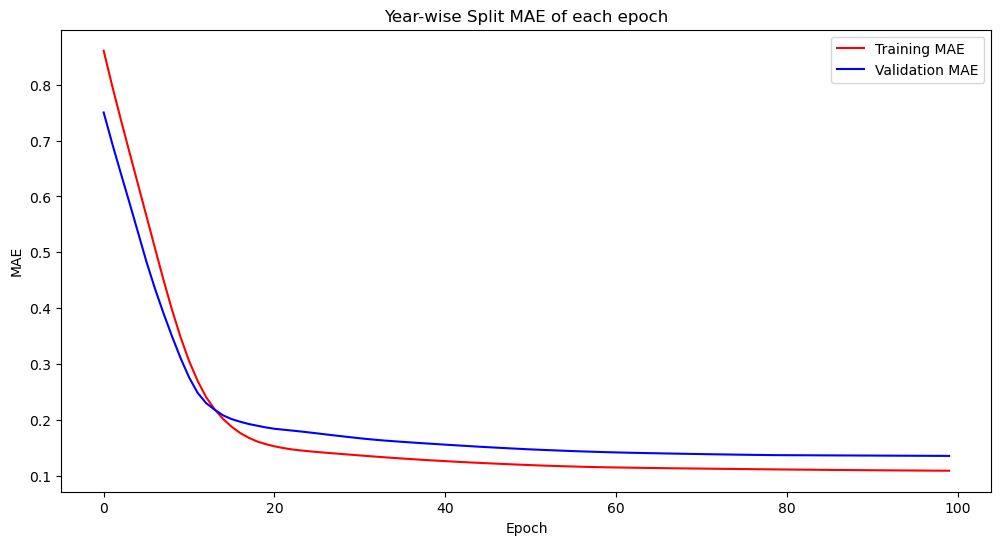

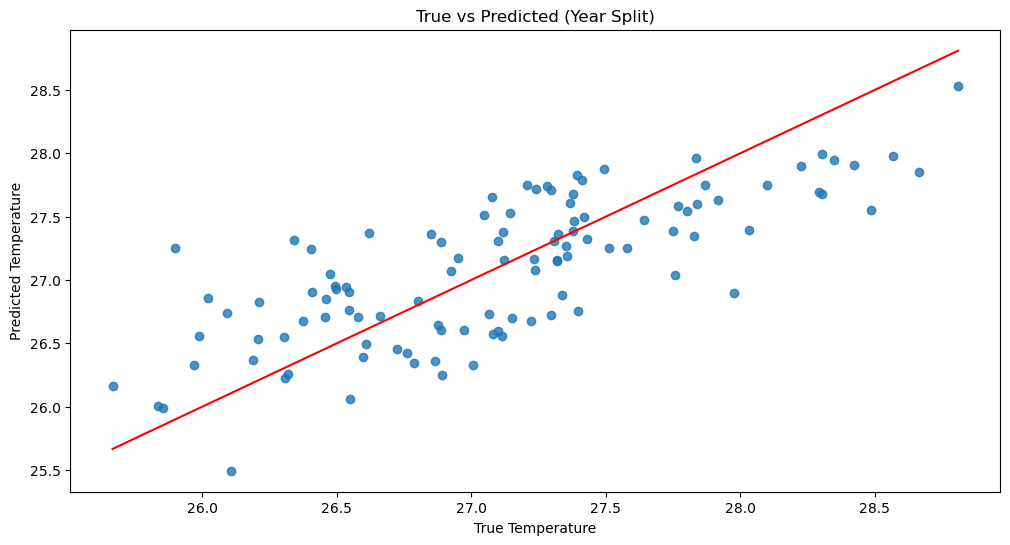

['target_scaler_taskB_yearwise.pkl']

In [6]:
# Model development (year-wise split & target normalisation) + Model evaluation (Year-wise Split)
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import joblib

# step p
# get unique year
de_year = hot_data['year'].unique()

# set random seed and shuffle
random.seed(42)
np.random.seed(42)
np.random.shuffle(de_year)

# split years: 60% - 20% - 20%
train_years = int(len(de_year) * 0.6)
val_years = int(len(de_year) * 0.2)

train_year = de_year[:train_years]
val_year = de_year[train_years:train_years + val_years]
test_year = de_year[train_years + val_years:]

# select samples from each year
split_train = hot_data[hot_data['year'].isin(train_year)]
split_val = hot_data[hot_data['year'].isin(val_year)]
split_test = hot_data[hot_data['year'].isin(test_year)]

# set up input features
features = ['TSA', 'ENSO', 'NAO', 'TNA', 'month_sin', 'month_cos']
x_train_year = split_train[features].values
x_val_year = split_val[features].values
x_test_year = split_test[features].values

# set up target
y_train_year = split_train['temperature'].values.reshape(-1, 1)
y_val_year = split_val['temperature'].values.reshape(-1, 1)
y_test_year = split_test['temperature'].values.reshape(-1, 1)

# step q
# set up feature scaler
scalerB_year = StandardScaler()
sc_x_train_year = scalerB_year.fit_transform(x_train_year)   #  fit scaler only on train data
sc_x_val_year = scalerB_year.transform(x_val_year)
sc_x_test_year = scalerB_year.transform(x_test_year)

# new scaler for target
target_scaler = MinMaxScaler()
sc_y_train_year = target_scaler.fit_transform(y_train_year)
sc_y_val_year = target_scaler.transform(y_val_year)
sc_y_test_year = target_scaler.transform(y_test_year)

# step r
# set up model
modelB_year = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(sc_x_train_year.shape[1],)),
    tf.keras.layers.Dense(3, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# complie model
modelB_year.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = 'mean_squared_error',
    metrics = ['mae']
)

# count parameters and sample
print("Trainable Parameters:", modelB_year.count_params())
print("Sample Count:", x_train_year.shape[0])

# add earlystop
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# model training
detailB_year = modelB_year.fit(
    sc_x_train_year, sc_y_train_year,
    validation_data = (sc_x_val_year, sc_y_val_year),
    epochs = 100, batch_size = 32, callbacks = [early_stop], verbose = 0
)

# step t
# predict on test set
sc_y_pred_year = modelB_year.predict(sc_x_test_year)
# turn predict result back to temperature
y_pred_year = target_scaler.inverse_transform(sc_y_pred_year)

# calculate MAE, r
mae_year = mean_absolute_error(y_test_year, y_pred_year)
r_year, _ = pearsonr(y_test_year.flatten(), y_pred_year.flatten())

# print metrics
print(f"Mean Absolute Error(MAE): {mae_year:.4f}")
print(f"Pearson Correlation Coefficient(r): {r_year:.4f}")

# loss per epoch curve
plt.figure(figsize=(12, 6))
plt.plot(detailB_year.history['loss'], color='red', label='Training Loss')
plt.plot(detailB_year.history['val_loss'], color='blue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Year-wise Split Loss of each epoch')
plt.legend()
plt.show()

# MAE per epoch curve
plt.figure(figsize=(12, 6))
plt.plot(detailB_year.history['mae'], color='red', label='Training MAE')
plt.plot(detailB_year.history['val_mae'], color='blue', label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Year-wise Split MAE of each epoch')
plt.legend()
plt.show()

# true vs predicted scatter
plt.figure(figsize=(12, 6))
plt.scatter(y_test_year, y_pred_year, alpha=0.8)
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.plot([y_test_year.min(), y_test_year.max()], [y_test_year.min(), y_test_year.max()], color='red')
plt.title('True vs Predicted (Year Split)')
plt.show()

# save model and scaler
modelB_year.save('model_taskB_yearwise.keras')
joblib.dump(scalerB_year, 'scaler_taskB_yearwise.pkl')
joblib.dump(target_scaler, 'target_scaler_taskB_yearwise.pkl')

# Test Code

======================================Task A======================================
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


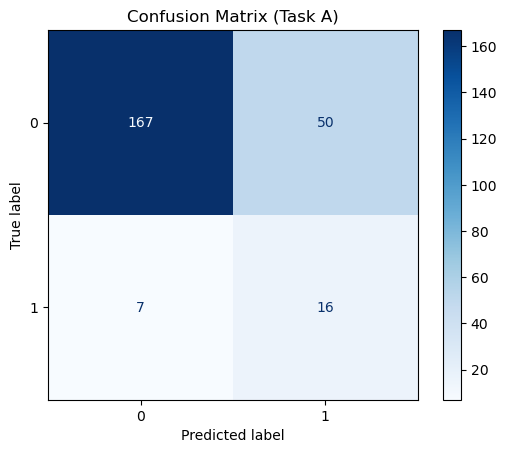

Balanced Accuracy: 0.7326
True Negative Rate: 0.7696
True Positive Rate: 0.6957
=================================Task B - Random Split==============================
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Random Split - Mean Absolute Error(MAE): 1.1146
Random Split - Pearson Correlation Coefficient(r): 0.2565


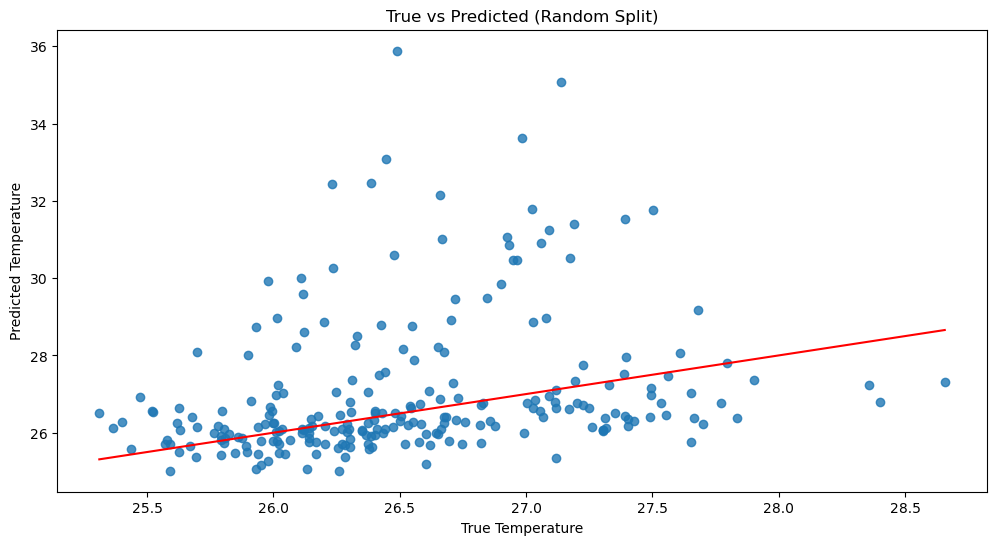

===================================Task B - Yearwise=================================
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Yearwise Split - Mean Absolute Error(MAE): 0.4235
Yearwise Split - Pearson Correlation Coefficient(r): 0.7639


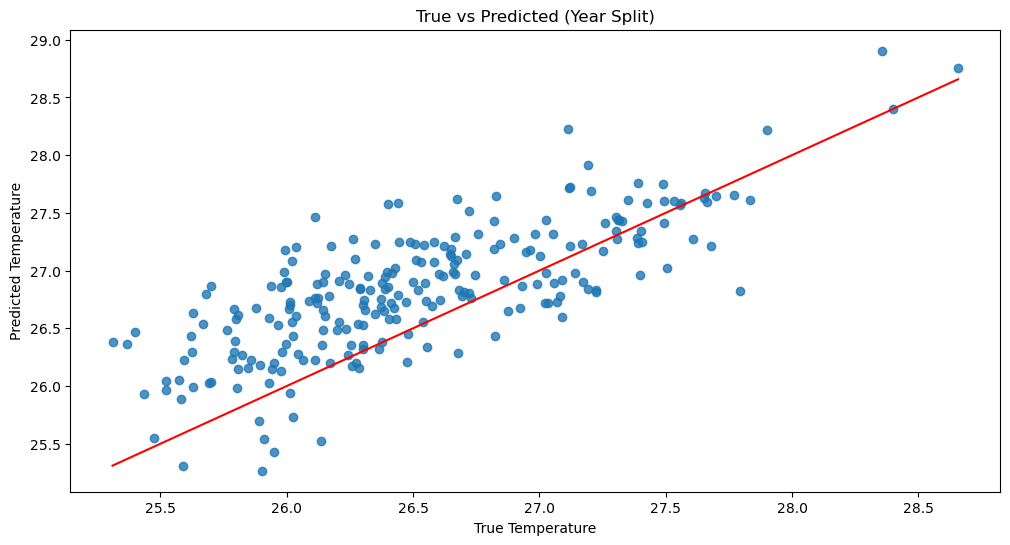

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import joblib

# load csv file
temperature_hidden = pd.read_csv('Amazon_temperature_testing.csv')
threshold_hidden = pd.read_csv('thresholds.csv')

hot_hidden_data = pd.merge(temperature_hidden, threshold_hidden, on='month', how='left')

hot_hidden_data['Hot'] = (hot_hidden_data['temperature'] > hot_hidden_data['threshold']).astype(int)

# add month - cyclic encoding
month = 2 * np.pi * (hot_hidden_data['month'] - 1) / 12
hot_hidden_data['month_sin'] = np.sin(month)
hot_hidden_data['month_cos'] = np.cos(month)

# load models and scalers
modelA = tf.keras.models.load_model('model_taskA.keras')
scalerA = joblib.load('scaler_taskA.pkl')

modelB = tf.keras.models.load_model('model_taskB.keras')
scalerB = joblib.load('scaler_taskB.pkl')

modelB_year = tf.keras.models.load_model('model_taskB_yearwise.keras')
scalerB_year = joblib.load('scaler_taskB_yearwise.pkl')
target_scalerB_year = joblib.load('target_scaler_taskB_yearwise.pkl')

# set random seed
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# input features
featureA = ['TSA', 'ENSO', 'NAO', 'TNA']
featureB = ['TSA', 'ENSO', 'NAO', 'TNA', 'month_sin', 'month_cos']

# Task A
print("======================================Task A======================================")

x_test_A = hot_hidden_data[featureA].values
y_test_A = hot_hidden_data['Hot'].values.astype(int)
sc_x_hidden_A = scalerA.transform(x_test_A)

y_pro_A = modelA.predict(sc_x_hidden_A)
y_pred_A = (y_pro_A > 0.5).astype(int).flatten()

# Confusion matrix
cm_hidden = confusion_matrix(y_test_A, y_pred_A, labels=[0, 1])
cmp_hidden = ConfusionMatrixDisplay(confusion_matrix=cm_hidden, display_labels=[0, 1])
cmp_hidden.plot(cmap='Blues')
plt.title('Confusion Matrix (Task A)')
plt.show()

# calculate metrics
tn_hidden, fp_hidden, fn_hidden, tp_hidden = cm_hidden.ravel()

tnr_hidden = tn_hidden / (tn_hidden + fp_hidden)
tpr_hidden = tp_hidden / (tp_hidden + fn_hidden)
balanced_acc_hidden = balanced_accuracy_score(y_test_A, y_pred_A)

# print metrics
print(f"Balanced Accuracy: {balanced_acc_hidden:.4f}")
print(f"True Negative Rate: {tnr_hidden:.4f}")
print(f"True Positive Rate: {tpr_hidden:.4f}")


# Task B - Random Split
print("=================================Task B - Random Split==============================")

x_test_B = hot_hidden_data[featureB].values
y_test_B = hot_hidden_data['temperature'].values
sc_x_hidden_B = scalerB.transform(x_test_B)

y_pred_B = modelB.predict(sc_x_hidden_B).flatten()
mae_hidden = mean_absolute_error(y_test_B, y_pred_B)
r_hidden, _ = pearsonr(y_test_B, y_pred_B)

# print metrics
print(f"Random Split - Mean Absolute Error(MAE): {mae_hidden:.4f}")
print(f"Random Split - Pearson Correlation Coefficient(r): {r_hidden:.4f}")

# Random split - true vs predicted scatter
plt.figure(figsize=(12, 6))
plt.scatter(y_test_B, y_pred_B, alpha=0.8)
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.plot([y_test_B.min(), y_test_B.max()], [y_test_B.min(), y_test_B.max()], color='red')
plt.title('True vs Predicted (Random Split)')
plt.show()



# Task B - Yearwise
print("===================================Task B - Yearwise=================================")

year_hidden = hot_hidden_data['year'].unique()
np.random.shuffle(year_hidden)

# select samples from each year
split_test_hidden = hot_hidden_data[hot_hidden_data['year'].isin(year_hidden)]
x_hidden_B_year = split_test_hidden[featureB].values
y_hidden_B_year = split_test_hidden['temperature'].values.reshape(-1, 1)

sc_x_hidden_B_year = scalerB_year.transform(x_hidden_B_year)
sc_y_pred_B_year = modelB_year.predict(sc_x_hidden_B_year)
y_pred_B_year = target_scalerB_year.inverse_transform(sc_y_pred_B_year)

mae_hidden_year = mean_absolute_error(y_hidden_B_year, y_pred_B_year)
r_hidden_year, _ = pearsonr(y_hidden_B_year.flatten(), y_pred_B`_year.flatten())

# print metrics
print(f"Yearwise Split - Mean Absolute Error(MAE): {mae_hidden_year:.4f}")
print(f"Yearwise Split - Pearson Correlation Coefficient(r): {r_hidden_year:.4f}")

# Yearwise split - true vs predicted scatter
plt.figure(figsize=(12, 6))
plt.scatter(y_hidden_B_year, y_pred_B_year, alpha=0.8)
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.plot([y_hidden_B_year.min(), y_hidden_B_year.max()], [y_hidden_B_year.min(), y_hidden_B_year.max()], color='red')
plt.title('True vs Predicted (Year Split)')
plt.show()